In [ ]:
from google.colab import drive 

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

**Exploratory Data Analysis**

In [ ]:
print(' The types of fraudulent transaction are {}'.format(list(df.loc[df.isFraud == 1].type.drop_duplicates().values)))

 The types of fraudulent transaction are ['TRANSFER', 'CASH_OUT']


In [ ]:
dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
print(' The number of fraudulent TRANSFER = {}'.format(len(dfFraudTransfer)))

 The number of fraudulent TRANSFER = 4097


In [ ]:
dfCashOut = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]
print(' The number of fraudulent TRANSFER = {}'.format(len(dfCashOut)))

 The number of fraudulent TRANSFER = 4116


In [ ]:
CountisFlaggedFraudWithTransfer = df.loc[(df.isFlaggedFraud == 1) & (df.type == 'TRANSFER')]
print('The type of transactions in which isFlaggedFraud is set:{}'.format(list(df.loc[df.isFlaggedFraud == 1].type.drop_duplicates())))

The type of transactions in which isFlaggedFraud is set:['TRANSFER']


In [ ]:
CountisFlaggedFraud = df.loc[(df.isFlaggedFraud == 1)]
len(CountisFlaggedFraud)

16

In [ ]:
{column: len(df[column].unique()) for column in df.columns}

{'amount': 5316900,
 'isFlaggedFraud': 2,
 'isFraud': 2,
 'nameDest': 2722362,
 'nameOrig': 6353307,
 'newbalanceDest': 3555499,
 'newbalanceOrig': 2682586,
 'oldbalanceDest': 3614697,
 'oldbalanceOrg': 1845844,
 'step': 743,
 'type': 5}

In [ ]:
df.shape

(6362620, 11)

Q3. How did you select variables to be included in the model?

Since there are only 16 entries of isFlaggedFraud to be true it does not corelate with any other variable so we are going to drop it and there is no use of step column we are going to drop it and the nameOrig is almost equal to the number of rows in the dataframe so the chances of uniqueness are very low so we are going to drop it and since,there is no relation of origin's name we have to assume there is no relation to reciever's name.

In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Q1. Data cleaning including missing values, outliers and multi-collinearity.

In [ ]:
def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [ ]:
def preprocess_inputs(df):
    df = df.copy()
    
    #drop the columns
    df = df.drop(['step', 'nameOrig', 'isFlaggedFraud','nameDest'], axis=1)

    # One-hot encode the type column
    df = onehot_encode(df, column='type', prefix='tp')

    y = df['isFraud'].copy()
    X = df.drop('isFraud', axis=1).copy()

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

     # Scale X with a standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    # Handling imbalanced data set
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(sampling_strategy='minority')
    X_sm, y_sm = smote.fit_resample(X_train, y_train)

    

    return X_sm, X_test, y_sm, y_test





In [ ]:
X_train, X_test, y_train, y_test = preprocess_inputs(df)

In [ ]:
y_train.value_counts()

0    5083530
1    5083530
Name: isFraud, dtype: int64

Q5. What are the key factors that predict fraudulent customer?

In [ ]:
X_train.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,tp_CASH_IN,tp_CASH_OUT,tp_DEBIT,tp_PAYMENT,tp_TRANSFER
0,-0.294472,-0.288640,-0.292359,-0.324045,-0.333521,-0.530824,-0.736570,-0.080918,1.399004,-0.302413
1,-0.269117,-0.288496,-0.292359,-0.324045,-0.333521,-0.530824,-0.736570,-0.080918,1.399004,-0.302413
2,0.114513,-0.284716,-0.292359,-0.324045,-0.291079,-0.530824,1.357645,-0.080918,-0.714794,-0.302413
3,0.062480,1.229113,1.281290,0.708309,0.561936,1.883864,-0.736570,-0.080918,-0.714794,-0.302413
4,-0.240721,1.697312,1.680975,-0.256834,-0.280659,1.883864,-0.736570,-0.080918,-0.714794,-0.302413


6. Do these factors make sense? If yes, How? If not, How not?

Yes,these factors makes sense since we ruled out the factors that does not contribute to the models, factors like amount involved in the transaction is always suspicious and should be taken into the account and so does the balance of the both the parties involved in transctions and the type of transfer is also a very key factor.


Q4. Demonstrate the performance of the model by using best set of tools.

***Modeling and Training***

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_3 (Dense)             (None, 64)                704       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________
None


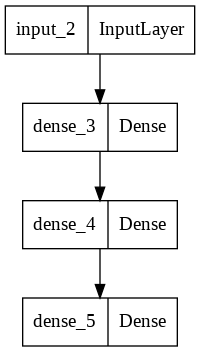

In [ ]:
# Inputs
X_inputs = tf.keras.Input(shape=(10,))

# X
X_dense1 = tf.keras.layers.Dense(64, activation='relu')(X_inputs)
X_dense2 = tf.keras.layers.Dense(64, activation='relu')(X_dense1)

# Output
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(X_dense2)

model = tf.keras.Model(inputs=X_inputs, outputs=outputs)

print(model.summary())
tf.keras.utils.plot_model(model)

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: {:.3f}%".format(results[1] * 100))
print("     Test AUC: {:.3f}".format(results[2] * 100))

Test Accuracy: 98.825%
     Test AUC: 99.867


In [ ]:
y_true = np.array(y_test)

y_pred = np.squeeze(model.predict(X_test))
y_pred = (y_pred >= 0.5).astype(np.int)


cm = confusion_matrix(y_true, y_pred)
clr = classification_report(y_true, y_pred, target_names=["Not Fraud", "Fraud"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


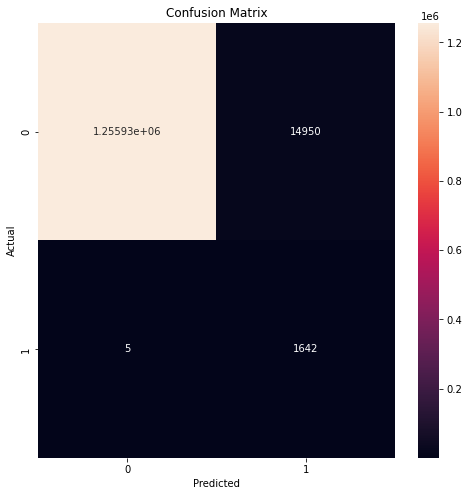

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

   Not Fraud       1.00      0.99      0.99   1270877
       Fraud       0.10      1.00      0.18      1647

    accuracy                           0.99   1272524
   macro avg       0.55      0.99      0.59   1272524
weighted avg       1.00      0.99      0.99   1272524



Q2. Describe your fraud detection model in elaboration.

The results provided confirmation that the data could be indeed be discriminated with the aid of the new features. To deal with such large data, we chose an appropriate metric and used a deep learning algorithm which works strongly on imbalanced classes.

Q7. What kind of prevention should be adopted while company update its infrastructure?

Company should screen public records of the applicants, analysis of financial patterns of the entity or individual,screen the entities for any negative news.


Q8. Assuming these actions have been implemented, how would you determine if they work?

To be effective in fraud detection, a machine learning model needs to be constantly improved and updated. Payment fraud detection can be eliminated for a while using ML. But sooner or later, fraudsters will come up with new tricks to game the system unless you keep it updated and this constant need to update the system is the only way we can determine that the model is working properly.


